In [44]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
import xgboost as xgb
import sklearn
import optuna
from itertools import combinations

In [21]:
def clean(ticker):
    ydf = yf.download(ticker, interval="1d")
    #ydf.to_csv(f'y{ticker}.csv')
    ydf.to_csv(f'test.csv')

    # btc = pd.read_csv(f'y{ticker}.csv')
    btc = pd.read_csv(f'test.csv')
    btc = btc.drop([0,1])
    btc['Date'] = pd.to_datetime(btc['Price']).dt.date
    # btc['Date'] = pd.to_datetime(btc['Price']).dt.floor('T')
    btc= btc.set_index('Date')
    btc = btc.drop(['Price'], axis = 1)
    btc = btc.reset_index()
    #btc['Ticker'] = ticker
    return btc

In [22]:
btc = clean('BTC-USD')
btc[btc.columns[1:]] = btc[btc.columns[1:]].astype(float)

btc

[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,2.105680e+07
1,2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,3.448320e+07
2,2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,3.791970e+07
3,2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,3.686360e+07
4,2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,2.658010e+07
...,...,...,...,...,...,...,...
3718,2024-11-21,98504.726562,98504.726562,99014.218750,94132.601562,94334.640625,1.060245e+11
3719,2024-11-22,98997.664062,98997.664062,99655.500000,97222.664062,98496.429688,7.847358e+10
3720,2024-11-23,97777.281250,97777.281250,99014.679688,97232.890625,99006.742188,4.441464e+10
3721,2024-11-24,98013.820312,98013.820312,98647.179688,95788.078125,97778.093750,5.171202e+10


In [23]:

btc['ret'] = btc['Adj Close'].pct_change()
btc['logret'] = np.log1p(btc['ret'])
btc['Gain'] = btc['logret'].apply(lambda x: x if x > 0 else 0)
btc['Loss'] = btc['logret'].apply(lambda x: -x if x < 0 else 0)

windows = [7, 15, 30, 60, 120, 180]

for i in windows:
    #rolling volatilities
    btc[f'vol_{i}'] = btc['logret'].rolling(window=i).std()

    #relative strength index
    btc[f'RSI_{i}'] = 100 - (100 / (1 + (btc['Gain'].rolling(window=i).mean() / btc['Loss'].rolling(window=i).mean())))

    # momentum score
    btc[f'mom_{i}'] = (1/i) * btc['logret'].rolling(i,i).sum().reset_index(drop=True)

    #exponential moving average
    btc[f'ewma_{i}'] = btc['logret'].ewm(span=i, min_periods=i).mean()

btc = btc.dropna().reset_index(drop=True)
btc['target'] = (btc['logret'].shift(-1) > 0).astype(int)
btc


,Date,Adj Close,Close,High,Low,Open,Volume,ret,logret,Gain,...,ewma_60,vol_120,RSI_120,mom_120,ewma_120,vol_180,RSI_180,mom_180,ewma_180,target
0,2015-03-16,290.592987,290.592987,294.112000,285.684998,285.684998,2.151610e+07,0.014665,0.014559,0.014559,...,0.003347,0.046246,46.023427,-0.002406,0.000585,0.043956,45.790611,-0.002519,-0.000496,0
1,2015-03-17,285.505005,285.505005,292.364990,284.373993,290.595001,2.149720e+07,-0.017509,-0.017664,0.000000,...,0.002656,0.046267,45.815970,-0.002543,0.000268,0.043637,46.280156,-0.002203,-0.000715,0
2,2015-03-18,256.299011,256.299011,285.335999,249.869995,285.066986,5.700800e+07,-0.102296,-0.107915,0.000000,...,-0.000978,0.047183,44.882128,-0.003176,-0.001610,0.044035,45.973818,-0.002400,-0.002080,1
3,2015-03-19,260.928009,260.928009,264.243988,248.636002,255.880005,5.273200e+07,0.018061,0.017900,0.017900,...,-0.000357,0.047196,44.937185,-0.003145,-0.001272,0.043972,45.799945,-0.002496,-0.001826,1
4,2015-03-20,261.748993,261.748993,264.847992,259.161987,260.955994,1.845670e+07,0.003146,0.003141,0.003141,...,-0.000242,0.046891,45.738199,-0.002606,-0.001195,0.043941,46.046612,-0.002340,-0.001763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3538,2024-11-21,98504.726562,98504.726562,99014.218750,94132.601562,94334.640625,1.060245e+11,0.044152,0.043205,0.043205,...,0.009881,0.028331,58.365830,0.003417,0.006144,0.026112,55.190140,0.001956,0.004592,1
3539,2024-11-22,98997.664062,98997.664062,99655.500000,97222.664062,98496.429688,7.847358e+10,0.005004,0.004992,0.004992,...,0.009721,0.028331,58.345671,0.003407,0.006125,0.026096,55.433094,0.002044,0.004597,0
3540,2024-11-23,97777.281250,97777.281250,99014.679688,97232.890625,99006.742188,4.441464e+10,-0.012327,-0.012404,0.000000,...,0.008995,0.028244,57.500260,0.003037,0.005818,0.026105,55.062763,0.001905,0.004409,1
3541,2024-11-24,98013.820312,98013.820312,98647.179688,95788.078125,97778.093750,5.171202e+10,0.002419,0.002416,0.002416,...,0.008780,0.028241,57.576920,0.003070,0.005762,0.026071,55.355414,0.002007,0.004387,0


In [24]:
X = btc[btc.columns[11:-1]]
y_class = btc['target']
y_reg = btc['ret']

In [25]:

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, shuffle=False)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, shuffle=False)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_class, y_train_class)

rf_predictions = rf_model.predict(X_test_class)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_class, y_train_class)

xgb_predictions = xgb_model.predict(X_test_class)

# Evaluate Models
print("Random Forest Accuracy:")
print(accuracy_score(y_test_class, rf_predictions))
print(classification_report(y_test_class, rf_predictions))

print("\nXGBoost Accuracy:")
print(accuracy_score(y_test_class, xgb_predictions))
print(classification_report(y_test_class, xgb_predictions))


Random Forest Accuracy:
0.4936530324400564
              precision    recall  f1-score   support

           0       0.48      0.42      0.45       349
           1       0.50      0.56      0.53       360

    accuracy                           0.49       709
   macro avg       0.49      0.49      0.49       709
weighted avg       0.49      0.49      0.49       709


XGBoost Accuracy:
0.49647390691114246
              precision    recall  f1-score   support

           0       0.48      0.37      0.42       349
           1       0.50      0.62      0.56       360

    accuracy                           0.50       709
   macro avg       0.49      0.49      0.49       709
weighted avg       0.49      0.50      0.49       709



In [26]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_reg, y_train_reg)

rf_predictions = rf_model.predict(X_test_reg)

rf_mse = mean_squared_error(y_test_reg, rf_predictions)
rf_r2 = r2_score(y_test_reg, rf_predictions)

print("Random Forest Results:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R-squared Score: {rf_r2}")


Random Forest Results:
Mean Squared Error: 0.0002505584091585951
R-squared Score: 0.6121072109995331


In [35]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train_reg, y_train_reg)

xgb_predictions = xgb_model.predict(X_test_reg)

xgb_mse = mean_squared_error(y_test_reg, xgb_predictions)
xgb_r2 = r2_score(y_test_reg, xgb_predictions)

print("\nXGBoost Results:")
print(f"Mean Squared Error: {xgb_mse}")
print(f"R-squared Score: {xgb_r2}")

xgb_model.feature_importances_


XGBoost Results:
Mean Squared Error: 0.000266532237548946
R-squared Score: 0.5873779158776675


array([0.02963966, 0.03505971, 0.10572448, 0.2981616 , 0.01995849,
       0.02990937, 0.03498641, 0.05564188, 0.02470211, 0.021894  ,
       0.0255609 , 0.02586641, 0.02268907, 0.01727399, 0.02456013,
       0.02800767, 0.01423921, 0.01728005, 0.02307039, 0.03634516,
       0.04045035, 0.01627086, 0.02448047, 0.02822763], dtype=float32)

In [ ]:
feature_indicies = xgb_model.feature_importances_.argsort()
worst = x.columns[feature_indicies][:3]
best = x.columns[feature_indicies][-3:]


print(f'Random Forest Best OoB Score: \n {xgb_model.oob_score_:.2f}')
print(f'Random Forest Best Max Depth: \n {best_depth}')
print(f'Random Forest Best Max Features: \n {best_features}')
print(f'Random Forest Most Important Features: \n {best}')
print(f'Random Forest Least Important Features: \n {worst}')

In [28]:
# Grid search for best R2 score
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "tree_method": trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"]),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train_reg, y_train_reg)

    score = sklearn.model_selection.cross_val_score(model, X_test_reg, y_test_reg, n_jobs=-1, cv=3, scoring='r2')
    r2_score = score.mean()
    return r2_score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2024-11-25 10:55:44,546] A new study created in memory with name: no-name-123ad70d-b489-479f-9d91-8a9a14c1138e
[I 2024-11-25 10:55:50,899] Trial 0 finished with value: 0.5030196298435475 and parameters: {'n_estimators': 101, 'learning_rate': 0.06879353607483828, 'max_depth': 8, 'min_child_weight': 2.0481367113073006, 'subsample': 0.8498292299864263, 'colsample_bytree': 0.9305114727040257, 'gamma': 1.9122251282360575e-08, 'reg_alpha': 5.879746661008841e-05, 'reg_lambda': 7.658342405619444e-06, 'tree_method': 'auto'}. Best is trial 0 with value: 0.5030196298435475.
[I 2024-11-25 10:55:53,112] Trial 1 finished with value: 0.44836963878745967 and parameters: {'n_estimators': 107, 'learning_rate': 0.07894543453889465, 'max_depth': 9, 'min_child_weight': 4.319891311801296, 'subsample': 0.7631173027790235, 'colsample_bytree': 0.5874347426532062, 'gamma': 3.175441619358749e-08, 'reg_alpha': 3.765353492058777e-05, 'reg_lambda': 0.00011013339202136097, 'tree_method': 'auto'}. Best is trial 0 

FrozenTrial(number=85, state=TrialState.COMPLETE, values=[0.5691705971381413], datetime_start=datetime.datetime(2024, 11, 25, 10, 58, 6, 544175), datetime_complete=datetime.datetime(2024, 11, 25, 10, 58, 8, 338747), params={'n_estimators': 964, 'learning_rate': 0.010878262502218456, 'max_depth': 3, 'min_child_weight': 1.111635099900371, 'subsample': 0.5442239160431641, 'colsample_bytree': 0.9480623160225468, 'gamma': 0.0005262878703219543, 'reg_alpha': 7.803499976356585e-06, 'reg_lambda': 2.0770778539374775e-08, 'tree_method': 'hist'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': 

<Figure size 1200x800 with 0 Axes>

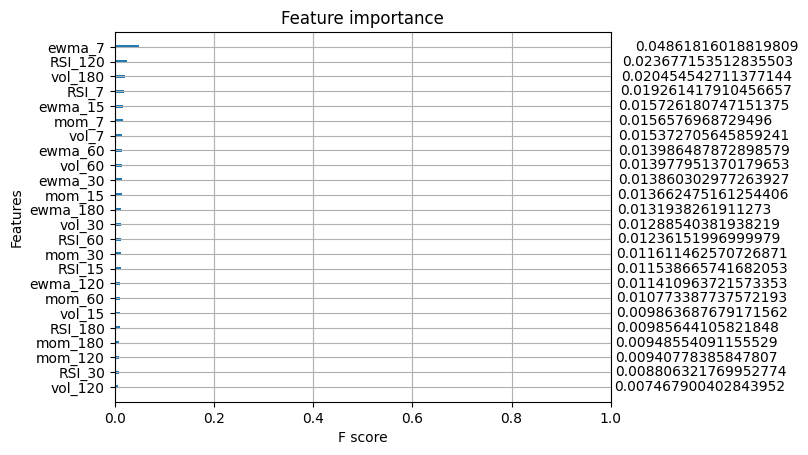

In [30]:
# params_r2 = {'n_estimators': 654, 
#           'learning_rate': 0.41560631208519555, 
#           'max_depth': 3, 
#           'min_child_weight': 1.9666756465978457, 
#           'subsample': 0.5485395239289113, 
#           'colsample_bytree': 0.6885282611378943, 
#           'gamma': 3.7589062962478, 
#           'reg_alpha': 0.004849800478451076, 
#           'reg_lambda': 1.582777002019766e-05, 
#           'tree_method': 'auto'}

params_r2 = {'n_estimators': 417, 'learning_rate': 0.03843972121093841, 'max_depth': 2, 'min_child_weight': 4.142211231912853, 'subsample': 0.6561841170406775, 'colsample_bytree': 0.9970154176313553, 'gamma': 1.3763533836520128e-07, 'reg_alpha': 0.004195523803265332, 'reg_lambda': 1.7333493784702013e-07, 'tree_method': 'auto'}

model = xgb.XGBRegressor(**params_r2, random_state=42)
model.fit(X_train_reg, y_train_reg)
#importance = model.get_booster().get_score(importance_type='gain')

# Assuming 'model' is your trained XGBoost model

# Adjust the figure size
plt.figure(figsize=(12, 8))

# Plot feature importance
ax = xgb.plot_importance(model.get_booster(), importance_type='gain')

# Adjust x-axis range if necessary
ax.set_xlim(0, 1)  # Modify the range to fit your data (optional)

# Adjust label size for better readability
ax.tick_params(axis='both', labelsize=10)

# Display the plot
plt.show()

# xgb.plot_importance(model.get_booster(), importance_type='gain')
# plt.show()

In [29]:
# Grid search for best MSE
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "tree_method": trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"]),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train_reg, y_train_reg)

    score = sklearn.model_selection.cross_val_score(model, X_test_reg, y_test_reg, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    mse =  score.mean()
    return mse

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2024-11-25 10:58:30,675] A new study created in memory with name: no-name-2be86a58-e5ec-4d4c-bd05-6e27264452dc
[I 2024-11-25 10:58:31,250] Trial 0 finished with value: -0.00041169633241294333 and parameters: {'n_estimators': 439, 'learning_rate': 0.06412285713858863, 'max_depth': 8, 'min_child_weight': 2.6734714549223386, 'subsample': 0.9008183230302524, 'colsample_bytree': 0.9213289081591454, 'gamma': 0.0019238350715468882, 'reg_alpha': 0.330032787076205, 'reg_lambda': 0.004482265088297588, 'tree_method': 'hist'}. Best is trial 0 with value: -0.00041169633241294333.
[I 2024-11-25 10:58:31,662] Trial 1 finished with value: -0.00045290492132514705 and parameters: {'n_estimators': 599, 'learning_rate': 0.3157693633168579, 'max_depth': 1, 'min_child_weight': 3.2375053837657353, 'subsample': 0.732371911542474, 'colsample_bytree': 0.6047424427770509, 'gamma': 0.027384774203546788, 'reg_alpha': 0.00024085664196545382, 'reg_lambda': 0.08556264964620919, 'tree_method': 'auto'}. Best is tria

FrozenTrial(number=93, state=TrialState.COMPLETE, values=[-0.0002793568287003329], datetime_start=datetime.datetime(2024, 11, 25, 10, 59, 38, 575237), datetime_complete=datetime.datetime(2024, 11, 25, 10, 59, 39, 528130), params={'n_estimators': 758, 'learning_rate': 0.019978758488573632, 'max_depth': 2, 'min_child_weight': 2.2969519630145654, 'subsample': 0.982105644687034, 'colsample_bytree': 0.8941876932310383, 'gamma': 1.444174196824637e-08, 'reg_alpha': 4.519076895864647e-06, 'reg_lambda': 4.5832238684818205e-06, 'tree_method': 'auto'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_byt

In [31]:
# params_mse={'n_estimators': 905,
#             'learning_rate': 0.5690905084189695, 
#             'max_depth': 2, 
#             'min_child_weight': 1.925022951585389, 
#             'subsample': 0.7027423437070898, 
#             'colsample_bytree': 0.7128179776032951, 
#             'gamma': 6.944872367285347, 
#             'reg_alpha': 0.18383908297791254, 
#             'reg_lambda': 0.0035713122604259274, 
#             'tree_method': 'hist'}

params_mse ={'n_estimators': 270, 
             'learning_rate': 0.023887610039222115, 
             'max_depth': 4, 
             'min_child_weight': 2.024388714685194, 
             'subsample': 0.6429271022216754, 
             'colsample_bytree': 0.9560107882573772, 
             'gamma': 1.1324720548925758e-05, 
             'reg_alpha': 0.005553800489043667, 
             'reg_lambda': 0.004930587488387167, 
             'tree_method': 'hist'}

model = xgb.XGBRegressor(**params_mse, random_state=42)
model.fit(X_train_reg, y_train_reg)
importance = model.get_booster().get_score(importance_type='gain')
# xgb.plot_importance(model.get_booster(), importance_type='cover')
# plt.show()
print(importance)
# for some reason this doesnt work. dont know why haha

{'vol_7': 0.009632255882024765, 'RSI_7': 0.011446389369666576, 'mom_7': 0.012586666271090508, 'ewma_7': 0.03622246906161308, 'vol_15': 0.006002978887408972, 'RSI_15': 0.007115346845239401, 'mom_15': 0.01020751055330038, 'ewma_15': 0.009701455011963844, 'vol_30': 0.0067848265171051025, 'RSI_30': 0.0062900735065341, 'mom_30': 0.00825122743844986, 'ewma_30': 0.0085759861394763, 'vol_60': 0.006634768098592758, 'RSI_60': 0.007075316738337278, 'mom_60': 0.007190381642431021, 'ewma_60': 0.007818319834768772, 'vol_120': 0.0058566429652273655, 'RSI_120': 0.006818703841418028, 'mom_120': 0.007606541272252798, 'ewma_120': 0.008429293520748615, 'vol_180': 0.006436874158680439, 'RSI_180': 0.008149255067110062, 'mom_180': 0.00601190933957696, 'ewma_180': 0.007667638827115297}


In [32]:
# Grid search for best MSE
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "tree_method": trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"]),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train_reg, y_train_reg)

    score = sklearn.model_selection.cross_val_score(model, X_test_reg, y_test_reg, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    mse =  score.mean()
    return mse

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2024-11-25 10:59:48,517] A new study created in memory with name: no-name-50e91df4-61a3-42c4-9272-dd18cf71f2e8
[I 2024-11-25 10:59:51,193] Trial 0 finished with value: -0.0003293711514521279 and parameters: {'n_estimators': 417, 'learning_rate': 0.08188770719667804, 'max_depth': 9, 'min_child_weight': 6.618165363129456, 'subsample': 0.7178194137243532, 'colsample_bytree': 0.8599275708351288, 'gamma': 3.2235323017956234e-05, 'reg_alpha': 0.0037589811135139498, 'reg_lambda': 0.1608338959687534, 'tree_method': 'approx'}. Best is trial 0 with value: -0.0003293711514521279.
[I 2024-11-25 10:59:51,668] Trial 1 finished with value: -0.0006463859320349752 and parameters: {'n_estimators': 574, 'learning_rate': 0.5118645003311894, 'max_depth': 9, 'min_child_weight': 1.4269578216970011, 'subsample': 0.87463869873519, 'colsample_bytree': 0.6667669710898181, 'gamma': 0.09303294931459563, 'reg_alpha': 0.00020561988533751086, 'reg_lambda': 0.001493147679165343, 'tree_method': 'auto'}. Best is tria

KeyboardInterrupt: 

In [34]:
OLS_model = LinearRegression()
#objective='reg:squarederror', n_estimators=100, random_state=42)
OLS_model.fit(X_train_reg, y_train_reg)

OLS_predictions = xgb_model.predict(X_test_reg)

OLS_mse = mean_squared_error(y_test_reg, OLS_predictions)
OLS_r2 = r2_score(y_test_reg, OLS_predictions)

print("\nXGBoost Results:")
print(f"Mean Squared Error: {OLS_mse}")
print(f"R-squared Score: {OLS_r2}")


XGBoost Results:
Mean Squared Error: 0.00018412386357936848
R-squared Score: 0.7149554101768899


In [47]:
#initialize values to track
best_r2 = 0
best_r2_features = None

#loop through all parameter combinations, keeping the best scores and combinations
for i in range(1, len(X_train_reg.columns) + 1):
    for combo in combinations(X.columns, i):
        X_train_subset = X_train_reg[list(combo)]
        X_test_subset = X_test_reg[list(combo)]

        model = LinearRegression()
        model.fit(X_train_subset, y_train_reg)
        #model = LinearRegression(X, X_subset).fit()
        r2 = model.score(X_test_subset, y_test_reg)
        
        if r2 > best_r2:
            best_r2 = r2
            best_r2_features = combo

#print the best scores and features
print("Best R2 Features:", best_r2_features, "Best R2 Score:", best_r2)


KeyboardInterrupt: 

In [ ]:
print("\nFinal Results:")
print(f"Best model from cross-validation: R2 = {best_r2:.4f}, Features = {best_r2_features}")

best_model = LinearRegression()
best_model.fit(X_test_reg[list(best_r2_features)], y_test_reg)

print("\nCoefficients of the best model:")
for feature, coef in zip(best_r2_features, best_model.coef_):
    print(f"{feature}: {coef:.6f}")
#print(f"Intercept: {best_model.intercept_:.6f}")


In [43]:
#run ridge regression
reg1 = RidgeCV(alphas=np.logspace(-6, 6, 13)) 
reg1.fit(X_train_reg, y_train_reg) 

ridge_r2 = reg1.score(X_test_reg, y_test_reg)

#run lasso regression
reg2 = LassoCV(alphas=np.logspace(-6, 6, 13), max_iter=10000) 
reg2.fit(X_train_reg, y_train_reg) 

lasso_r2 = reg2.score(X_test_reg, y_test_reg)

#print tupe of R^2 values
print(("Ridge R^2 Value:", "Lasso R^2 Value:"), "=", (ridge_r2, lasso_r2))

('Ridge R^2 Value:', 'Lasso R^2 Value:') = (0.7155378290337184, 0.6794718937759737)


In [ ]:
# print("\nCoefficients of the best model:")
# for feature, coef in zip(lasso, best_model.coef_):
#     print(f"{feature}: {coef:.6f}")